In [1]:
import sys
sys.path.append('../')

import thermonets as tn
import numpy as np
import heyoka as hy
import pykep as pk
import pygmo as pg

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

## NRLMSISE-00 fit:

We now open the NRLMSISE-00 database and shuffle it:

In [2]:
# day, month, year, hour, minute, second, microsecond, [7] alt [km], lat [deg], lon [deg], [10] f107A, f107, [12] ap, [13] density [kg/m^3]
db = np.loadtxt("../dbs/nrlmsise00_db.txt", skiprows=1, delimiter=",")
np.random.shuffle(db)

In [3]:
#we print to screen some of the database characteristics:
db_size = db.shape[0]
minh = np.min(db[:, 7])
maxh = np.max(db[:, 7])
print(f"db size is: {db_size}")
print(f"Altitude range is: {minh:.3f} - {maxh:.3f}")
print(f"Ad range is: {np.min(db[:, 12]):.3f} - { np.max(db[:, 12]):.3f}")
print(f"F107 range is: {np.min(db[:, 11]):.3f} - { np.max(db[:, 11]):.3f}")
print(f"density range is: {np.min(db[:, -1]):.3e} - { np.max(db[:, -1]):.3e}")

db size is: 999700
Altitude range is: 180.000 - 1000.000
Ad range is: 0.000 - 108.000
F107 range is: 64.000 - 262.000
density range is: 1.956e-16 - 7.633e-10


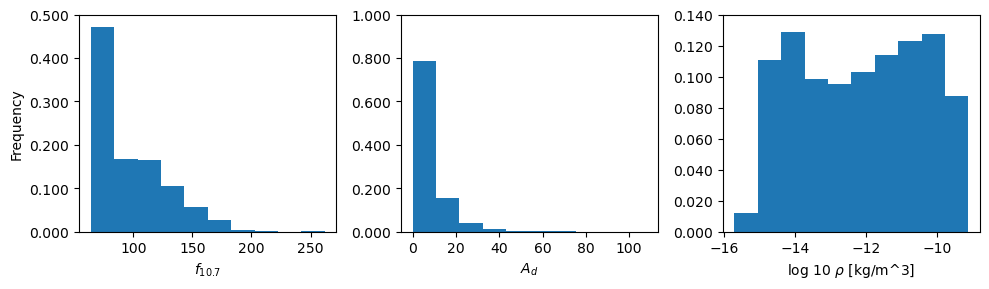

In [4]:
fig, ax = plt.subplots(1,3, figsize=(10,3))

#
ax[0].hist(db[:, 11])
ax[0].set_xlabel("$f_{10.7}$")
ax[0].set_ylabel("Frequency")
yticks = ax[0].get_yticks()
ax[0].set_yticks(yticks)
ax[0].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

#
ax[1].hist(db[:, 12])
ax[1].set_xlabel("$A_d$")
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

#
ax[2].hist(np.log10(db[:, -1]))
ax[2].set_xlabel("log 10 $\\rho$ [kg/m^3]")
yticks = ax[2].get_yticks()
ax[2].set_yticks(yticks)
ax[2].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

plt.tight_layout()

In [5]:
db.shape

(999700, 16)

we now learn a global fit:

In [6]:
n=4 # number of exp terms
udp = tn.global_fit_udp(db[::100, 7], db[::100,-1], n=n)
prob = pg.problem(udp)
uda = pg.sade(50, memory=True)
algo = pg.algorithm(uda)
pop  =pg.population(prob, 20)

In [9]:
for i in range(150):
    pop = algo.evolve(pop)
    print(f"at iter {i} - {pop.champion_f[0]:.6f}", end = "\r")
best_fit_x = pop.champion_x

Let's look at the best fit:

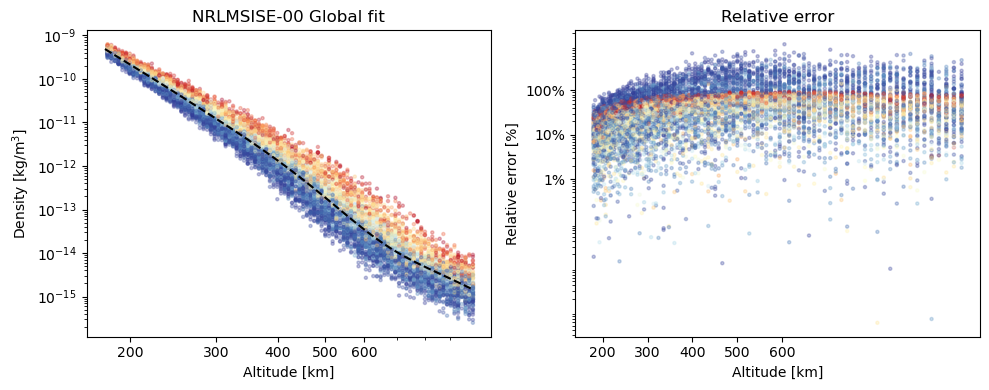

In [11]:
alts = np.logspace(2.25,3)
predicted = tn.rho_approximation(db[::100,7], best_fit_x)
fig, ax = plt.subplots(1,2, figsize = (10,4))
cm = plt.colormaps['RdYlBu']


#
sc = ax[0].scatter(db[::100,7], db[::100,-1], alpha=0.3, c=1-db[::100,10]/np.max(db[::100,10]), s=5, cmap=cm)
ax[0].loglog(alts, tn.rho_approximation(alts, best_fit_x), 'k--')
ax[0].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])
ax[0].set_title("NRLMSISE-00 Global fit")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Density [kg/m$^3$]")


#
rel_err = np.abs(predicted - db[::100,-1]) / np.linalg.norm(db[::100,-1:], axis=1) * 100
ax[1].scatter(db[::100,7], rel_err, alpha=0.3, c=1-db[::100,10]/np.max(db[::100,10]), s=5, cmap=cm)
ax[1].set_yscale('log')
ax[1].set_yticks([1, 10, 100], ["1%", "10%", "100%"])
ax[1].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])
ax[1].set_title("Relative error")
ax[1].set_xlabel("Altitude [km]")
ax[1].set_ylabel("Relative error [%]")

plt.tight_layout()
plt.savefig("global_fit", dpi=600)

## JB-08 fit:

We now open the JB-08 database and shuffle it:

In [12]:
# day, month, year, hour, minute, second, microsecond, alt [km], lat [deg], lon [deg], sun ra [deg], sun dec [deg], f107, f107A, s107, s107A, m107, m107A, y107, y107A, dDstdT, density [kg/m^3]
db = np.loadtxt("../dbs/jb08_db.txt", skiprows=1, delimiter=",")
np.random.shuffle(db)

In [13]:
#we print to screen some of the database characteristics:
db_size = db.shape[0]
minh = np.min(db[:, 7])
maxh = np.max(db[:, 7])
print(f"db size is: {db_size}")
print(f"Altitude range is: {minh:.3f} - {maxh:.3f}")
print(f"density range is: {np.min(db[:, -1]):.3e} - { np.max(db[:, -1]):.3e}")

db size is: 1000000
Altitude range is: 180.000 - 1000.000
density range is: 5.854e-16 - 7.462e-10


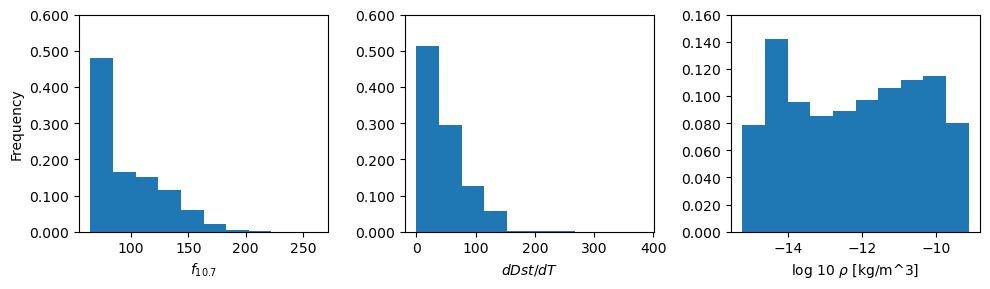

In [14]:
fig, ax = plt.subplots(1,3, figsize=(10,3))

#
ax[0].hist(db[:, 12])
ax[0].set_xlabel("$f_{10.7}$")
ax[0].set_ylabel("Frequency")
yticks = ax[0].get_yticks()
ax[0].set_yticks(yticks)
ax[0].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

#
ax[1].hist(db[:, 20])
ax[1].set_xlabel("$dDst/dT$")
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

#
ax[2].hist(np.log10(db[:, -1]))
ax[2].set_xlabel("log 10 $\\rho$ [kg/m^3]")
yticks = ax[2].get_yticks()
ax[2].set_yticks(yticks)
ax[2].set_yticklabels([f"{it/db_size:.3f}" for it in yticks])

plt.tight_layout()

Now we learn a global fit

In [30]:
n=4 # number of exp terms
udp = tn.global_fit_udp(db[::100, 7], db[::100,-1], n=n)
prob = pg.problem(udp)
uda = pg.sade(1, memory=True)
algo = pg.algorithm(uda)
pop  =pg.population(prob, 20)

In [32]:
for i in range(10000):
    pop = algo.evolve(pop)
    print(f"at iter {i} - {pop.champion_f[0]:.6f}", end = "\r")
best_fit_x = pop.champion_x
#with open('global_fit_jb08_180.0-1000.0-4.txt','wb') as f:
#    pickle.dump(best_fit_x, f)

Let's look at the best fit

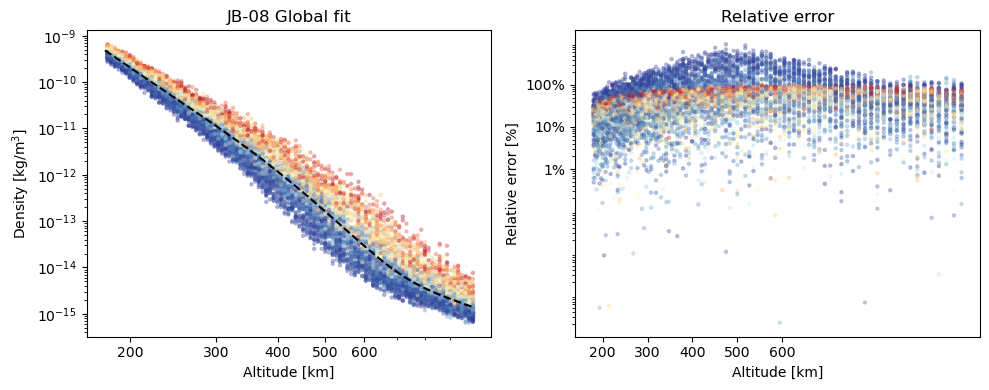

In [43]:
alts = np.logspace(2.25,3)
predicted = tn.rho_approximation(db[::100,7], best_fit_x)
fig, ax = plt.subplots(1,2, figsize = (10,4))
cm = plt.colormaps['RdYlBu']


#
sc = ax[0].scatter(db[::100,7], db[::100,-1], alpha=0.3, c=1-db[::100,13]/np.max(db[::100,13]), s=5, cmap=cm)
ax[0].loglog(alts, tn.rho_approximation(alts, best_fit_x), 'k--')
ax[0].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])
ax[0].set_title("JB-08 Global fit")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Density [kg/m$^3$]")


#
rel_err = np.abs(predicted - db[::100,-1]) / np.linalg.norm(db[::100,-1:], axis=1) * 100
ax[1].scatter(db[::100,7], rel_err, alpha=0.3, c=1-db[::100,13]/np.max(db[::100,13]), s=5, cmap=cm)
ax[1].set_yscale('log')
ax[1].set_yticks([1, 10, 100], ["1%", "10%", "100%"])
ax[1].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])
ax[1].set_title("Relative error")
ax[1].set_xlabel("Altitude [km]")
ax[1].set_ylabel("Relative error [%]")

plt.tight_layout()
plt.savefig("global_fit", dpi=600)